In [1]:
import numpy as np
import keras
import tensorflow
from keras import layers
from keras.models import Sequential
from keras import callbacks
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from matplotlib import pyplot
import os

logdir = os.path.join("callbacks")

In [68]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# load dataset
dataset = pd.read_csv('line_1283.csv', header=0, index_col=0)
dataset = dataset.loc[:, ['Power', 'holidays', 'Hour', 'Days', 'Month', 'Temperature', 'humiduity', 'Wind_speed']]
print(dataset.head())
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9, 10, 11, 12, 13, 14, 15]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train_hours = 529 * 48 - 1
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

   Power  holidays  Hour  Days  Month  Temperature  humiduity  Wind_speed
0  0.686         0   0.0    14      7         11.8       93.0        14.4
1  0.159         0   0.5    14      7         11.8       91.0        14.4
2  0.144         0   1.0    14      7         11.8       89.0        18.0
3  0.098         0   1.5    14      7         11.6       91.0        18.0
4  0.086         0   2.0    14      7         11.4       93.0        10.8
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.127256        0.0   0.000000   0.433333   0.545455   0.673469   
2   0.028195        0.0   0.021277   0.433333   0.545455   0.673469   
3   0.025376        0.0   0.042553   0.433333   0.545455   0.673469   
4   0.016729        0.0   0.063830   0.433333   0.545455   0.667639   
5   0.014474        0.0   0.085106   0.433333   0.545455   0.661808   

   var7(t-1)  var8(t-1)   var1(t)  
1       0.93   0.166667  0.028195  
2       0.91   0.166667  0.025376  
3       0.89   0.2222

In [3]:
def build_model(n_hidden=1, n_neurons=50, learning_rate=1e-1, input_shape=(train_X.shape[1], train_X.shape[2])):
    model = Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(layers.LSTM(n_neurons, return_sequences=True, activation="relu"))
        model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1))
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss='mae', metrics=['mape'])
    return model

keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

param_distribs= {
    "n_hidden": np.arange(1, 10).tolist(),
    "n_neurons": np.arange(1, 300).tolist(),
    "learning_rate": [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
}

checkpoint_cb = keras.callbacks.ModelCheckpoint('load_forecasting_New_best.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=5)
rnd_search_cv.fit(train_X, train_y, epochs=150, validation_split=0.1, shuffle=True, batch_size=32,
                  callbacks=[checkpoint_cb, early_stopping_cb])


print(rnd_search_cv.best_params_)
print('score:', rnd_search_cv.best_score_)

Epoch 1/150
572/572 [==============================] - 10s 8ms/step - loss: 0.0525 - mape: 188.9799 - val_loss: 0.0476 - val_mape: 92.7689
Epoch 2/150
572/572 [==============================] - 4s 6ms/step - loss: 0.0503 - mape: 537.2789 - val_loss: 0.0462 - val_mape: 85.3785
Epoch 3/150
572/572 [==============================] - 4s 6ms/step - loss: 0.0484 - mape: 859.5462 - val_loss: 0.0448 - val_mape: 78.0771
Epoch 4/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0477 - mape: 2842.9634 - val_loss: 0.0435 - val_mape: 72.6627
Epoch 5/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0460 - mape: 1178.7657 - val_loss: 0.0423 - val_mape: 68.6189
Epoch 6/150
572/572 [==============================] - 3s 5ms/step - loss: 0.0449 - mape: 2220.9396 - val_loss: 0.0413 - val_mape: 66.7956
Epoch 7/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0442 - mape: 951.7704 - val_loss: 0.0404 - val_mape: 66.1985
Epoch 8/150
572/572 [=========

572/572 [==============================] - 3s 6ms/step - loss: 0.0341 - mape: 10488.6620 - val_loss: 0.0345 - val_mape: 103.2642
Epoch 37/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0342 - mape: 6727.3039 - val_loss: 0.0345 - val_mape: 103.2979
Epoch 38/150
572/572 [==============================] - 4s 6ms/step - loss: 0.0338 - mape: 6055.8529 - val_loss: 0.0345 - val_mape: 103.3743
Epoch 39/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0343 - mape: 7414.4337 - val_loss: 0.0345 - val_mape: 103.4951
Epoch 40/150
572/572 [==============================] - 4s 6ms/step - loss: 0.0349 - mape: 6219.4674 - val_loss: 0.0345 - val_mape: 103.5420
Epoch 41/150
572/572 [==============================] - 4s 7ms/step - loss: 0.0348 - mape: 3450.1892 - val_loss: 0.0345 - val_mape: 103.5649
Epoch 42/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0334 - mape: 10110.7443 - val_loss: 0.0345 - val_mape: 103.6477
Epoch 43/150
572/572 [==

Epoch 23/150
572/572 [==============================] - 5s 9ms/step - loss: 0.0338 - mape: 96.8044 - val_loss: 0.0344 - val_mape: 105.8142
Epoch 24/150
572/572 [==============================] - 6s 10ms/step - loss: 0.0339 - mape: 98.5027 - val_loss: 0.0343 - val_mape: 108.7067
Epoch 25/150
572/572 [==============================] - 5s 9ms/step - loss: 0.0340 - mape: 102.2840 - val_loss: 0.0343 - val_mape: 111.4447
Epoch 26/150
572/572 [==============================] - 5s 9ms/step - loss: 0.0335 - mape: 104.6560 - val_loss: 0.0343 - val_mape: 113.7525
Epoch 27/150
572/572 [==============================] - 6s 10ms/step - loss: 0.0333 - mape: 105.8289 - val_loss: 0.0342 - val_mape: 115.9486
Epoch 28/150
572/572 [==============================] - 5s 9ms/step - loss: 0.0332 - mape: 109.6678 - val_loss: 0.0342 - val_mape: 117.7943
Epoch 29/150
572/572 [==============================] - 5s 9ms/step - loss: 0.0336 - mape: 109.6401 - val_loss: 0.0342 - val_mape: 119.3007
Epoch 30/150
572/572

Epoch 44/150
572/572 [==============================] - 11s 20ms/step - loss: 0.0378 - mape: 5346.9501 - val_loss: 0.0342 - val_mape: 115.6970
Epoch 45/150
572/572 [==============================] - 11s 19ms/step - loss: 0.0367 - mape: 11686.3897 - val_loss: 0.0342 - val_mape: 115.7072
Epoch 46/150
572/572 [==============================] - 11s 19ms/step - loss: 0.0373 - mape: 13493.8135 - val_loss: 0.0342 - val_mape: 115.7162
Epoch 47/150
572/572 [==============================] - 10s 18ms/step - loss: 0.0374 - mape: 14092.9145 - val_loss: 0.0342 - val_mape: 115.7585
Epoch 48/150
572/572 [==============================] - 11s 20ms/step - loss: 0.0375 - mape: 20763.2103 - val_loss: 0.0342 - val_mape: 115.6582
Epoch 49/150
572/572 [==============================] - 11s 20ms/step - loss: 0.0373 - mape: 11322.1728 - val_loss: 0.0342 - val_mape: 115.6661
Epoch 50/150
572/572 [==============================] - 11s 19ms/step - loss: 0.0383 - mape: 8905.6229 - val_loss: 0.0342 - val_mape: 115

Epoch 36/150
572/572 [==============================] - 11s 19ms/step - loss: 0.0343 - mape: 8995.9065 - val_loss: 0.0344 - val_mape: 103.7778
Epoch 37/150
572/572 [==============================] - 11s 19ms/step - loss: 0.0340 - mape: 7287.0751 - val_loss: 0.0344 - val_mape: 103.7843
Epoch 38/150
572/572 [==============================] - 12s 20ms/step - loss: 0.0342 - mape: 10367.3009 - val_loss: 0.0344 - val_mape: 103.7540
Epoch 39/150
572/572 [==============================] - 12s 21ms/step - loss: 0.0352 - mape: 4436.5211 - val_loss: 0.0344 - val_mape: 103.7744
Epoch 40/150
572/572 [==============================] - 12s 21ms/step - loss: 0.0339 - mape: 9021.0920 - val_loss: 0.0345 - val_mape: 103.6425
Epoch 41/150
572/572 [==============================] - 12s 21ms/step - loss: 0.0344 - mape: 7459.9478 - val_loss: 0.0345 - val_mape: 103.6148
Epoch 42/150
572/572 [==============================] - 12s 21ms/step - loss: 0.0337 - mape: 4317.1914 - val_loss: 0.0345 - val_mape: 103.676

Epoch 31/150
572/572 [==============================] - 8s 13ms/step - loss: 0.0350 - mape: 12452.7741 - val_loss: 0.0342 - val_mape: 121.0140
Epoch 32/150
572/572 [==============================] - 9s 15ms/step - loss: 0.0356 - mape: 10053.3138 - val_loss: 0.0342 - val_mape: 121.0928
Epoch 33/150
572/572 [==============================] - 9s 16ms/step - loss: 0.0349 - mape: 7253.8793 - val_loss: 0.0342 - val_mape: 121.1440
Epoch 34/150
572/572 [==============================] - 9s 15ms/step - loss: 0.0350 - mape: 6954.5066 - val_loss: 0.0342 - val_mape: 121.1137
Epoch 35/150
572/572 [==============================] - 9s 15ms/step - loss: 0.0360 - mape: 11824.2781 - val_loss: 0.0342 - val_mape: 121.0557
Epoch 36/150
572/572 [==============================] - 9s 15ms/step - loss: 0.0352 - mape: 13356.4929 - val_loss: 0.0342 - val_mape: 121.1490
Epoch 37/150
572/572 [==============================] - 8s 15ms/step - loss: 0.0352 - mape: 7746.4296 - val_loss: 0.0342 - val_mape: 121.1364
Ep

Epoch 145/150
572/572 [==============================] - 7s 12ms/step - loss: 0.0354 - mape: 11531.1259 - val_loss: 0.0340 - val_mape: 121.4047
Epoch 146/150
572/572 [==============================] - 7s 13ms/step - loss: 0.0351 - mape: 5045.3339 - val_loss: 0.0340 - val_mape: 121.4587
Epoch 147/150
572/572 [==============================] - 8s 14ms/step - loss: 0.0349 - mape: 12004.5147 - val_loss: 0.0340 - val_mape: 121.3553
Epoch 148/150
572/572 [==============================] - 7s 12ms/step - loss: 0.0356 - mape: 5663.8077 - val_loss: 0.0340 - val_mape: 121.2905
Epoch 149/150
572/572 [==============================] - 7s 12ms/step - loss: 0.0346 - mape: 5869.9991 - val_loss: 0.0340 - val_mape: 121.4075
Epoch 150/150
159/159 [==============================] - 1s 3ms/step - loss: 0.0358 - mape: 120.5328
Epoch 1/150
572/572 [==============================] - 15s 15ms/step - loss: 0.0496 - mape: 97.6830 - val_loss: 0.0472 - val_mape: 90.3458
Epoch 2/150
572/572 [======================

Epoch 110/150
572/572 [==============================] - 7s 11ms/step - loss: 0.0337 - mape: 116.8864 - val_loss: 0.0342 - val_mape: 125.2777
Epoch 111/150
572/572 [==============================] - 6s 11ms/step - loss: 0.0331 - mape: 115.4485 - val_loss: 0.0342 - val_mape: 125.1402
Epoch 112/150
572/572 [==============================] - 6s 11ms/step - loss: 0.0335 - mape: 115.5885 - val_loss: 0.0342 - val_mape: 125.0505
Epoch 113/150
572/572 [==============================] - 6s 11ms/step - loss: 0.0335 - mape: 114.4936 - val_loss: 0.0342 - val_mape: 125.1514
Epoch 114/150
572/572 [==============================] - 6s 11ms/step - loss: 0.0336 - mape: 116.1842 - val_loss: 0.0342 - val_mape: 125.0725
Epoch 115/150
572/572 [==============================] - 7s 11ms/step - loss: 0.0337 - mape: 116.2654 - val_loss: 0.0342 - val_mape: 125.0751
Epoch 116/150
572/572 [==============================] - 6s 11ms/step - loss: 0.0337 - mape: 117.2550 - val_loss: 0.0342 - val_mape: 125.1656
Epoch 

Epoch 17/150
572/572 [==============================] - 8s 14ms/step - loss: 0.0355 - mape: 12557.0611 - val_loss: 0.0408 - val_mape: 28641.0137
Epoch 18/150
572/572 [==============================] - 8s 14ms/step - loss: 0.0356 - mape: 2358.4583 - val_loss: 0.0410 - val_mape: 29449.7891
Epoch 19/150
572/572 [==============================] - 8s 14ms/step - loss: 0.0364 - mape: 4124.4208 - val_loss: 0.0411 - val_mape: 30064.7910
Epoch 20/150
572/572 [==============================] - 8s 14ms/step - loss: 0.0354 - mape: 9043.2601 - val_loss: 0.0412 - val_mape: 30551.0645
Epoch 21/150
572/572 [==============================] - 9s 15ms/step - loss: 0.0355 - mape: 3819.1932 - val_loss: 0.0413 - val_mape: 30951.6309
Epoch 22/150
159/159 [==============================] - 1s 4ms/step - loss: 0.0313 - mape: 90.3976
Epoch 1/150
572/572 [==============================] - 2s 2ms/step - loss: 0.0800 - mape: 12916.8081 - val_loss: 0.0700 - val_mape: 210.1957
Epoch 2/150
572/572 [==================

Epoch 110/150
572/572 [==============================] - 1s 2ms/step - loss: 0.0308 - mape: 6833.3397 - val_loss: 0.0254 - val_mape: 129.3773
Epoch 111/150
572/572 [==============================] - 1s 2ms/step - loss: 0.0322 - mape: 23435.0768 - val_loss: 0.0254 - val_mape: 129.6717
Epoch 112/150
572/572 [==============================] - 1s 2ms/step - loss: 0.0323 - mape: 14403.1961 - val_loss: 0.0254 - val_mape: 129.6608
Epoch 113/150
572/572 [==============================] - 1s 2ms/step - loss: 0.0317 - mape: 11005.6974 - val_loss: 0.0254 - val_mape: 129.8743
Epoch 114/150
572/572 [==============================] - 1s 2ms/step - loss: 0.0321 - mape: 15504.1087 - val_loss: 0.0254 - val_mape: 130.1816
Epoch 115/150
572/572 [==============================] - 1s 2ms/step - loss: 0.0322 - mape: 7248.0916 - val_loss: 0.0254 - val_mape: 130.3290
Epoch 116/150
572/572 [==============================] - 1s 2ms/step - loss: 0.0314 - mape: 7780.2494 - val_loss: 0.0253 - val_mape: 129.4341
Ep

572/572 [==============================] - 1s 1ms/step - loss: 0.0309 - mape: 11155.1143 - val_loss: 0.0276 - val_mape: 84.5170
Epoch 76/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0310 - mape: 12081.9373 - val_loss: 0.0276 - val_mape: 84.5762
Epoch 77/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0312 - mape: 4524.3334 - val_loss: 0.0276 - val_mape: 84.4585
Epoch 78/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0323 - mape: 2958.2199 - val_loss: 0.0275 - val_mape: 84.3275
Epoch 79/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0307 - mape: 8445.7082 - val_loss: 0.0274 - val_mape: 84.7498
Epoch 80/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0310 - mape: 9073.3079 - val_loss: 0.0274 - val_mape: 84.6447
Epoch 81/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0313 - mape: 5628.4208 - val_loss: 0.0274 - val_mape: 84.8258
Epoch 82/150
572/572 [=========

572/572 [==============================] - 1s 1ms/step - loss: 0.0341 - mape: 11302.4016 - val_loss: 0.0275 - val_mape: 122.6642
Epoch 41/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0334 - mape: 13769.2614 - val_loss: 0.0274 - val_mape: 122.6344
Epoch 42/150
572/572 [==============================] - 1s 2ms/step - loss: 0.0336 - mape: 10144.1397 - val_loss: 0.0273 - val_mape: 122.4049
Epoch 43/150
572/572 [==============================] - 1s 2ms/step - loss: 0.0342 - mape: 14543.3717 - val_loss: 0.0272 - val_mape: 123.2613
Epoch 44/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0332 - mape: 6535.1772 - val_loss: 0.0272 - val_mape: 122.2334
Epoch 45/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0336 - mape: 5742.3077 - val_loss: 0.0271 - val_mape: 121.8775
Epoch 46/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0329 - mape: 15915.7425 - val_loss: 0.0270 - val_mape: 121.7142
Epoch 47/150
572/572 

Epoch 98/150
572/572 [==============================] - 1s 2ms/step - loss: 0.0317 - mape: 4970.6962 - val_loss: 0.0252 - val_mape: 124.7382
Epoch 99/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0311 - mape: 5487.7496 - val_loss: 0.0252 - val_mape: 124.5734
Epoch 100/150
572/572 [==============================] - 1s 2ms/step - loss: 0.0320 - mape: 9553.9608 - val_loss: 0.0252 - val_mape: 124.9115
Epoch 101/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0314 - mape: 14750.1854 - val_loss: 0.0252 - val_mape: 125.2693
Epoch 102/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0315 - mape: 8536.2702 - val_loss: 0.0251 - val_mape: 124.9742
Epoch 103/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0311 - mape: 3610.5142 - val_loss: 0.0251 - val_mape: 125.3196
Epoch 104/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0311 - mape: 9323.3725 - val_loss: 0.0251 - val_mape: 125.5513
Epoch 1

572/572 [==============================] - 1s 2ms/step - loss: 0.0357 - mape: 108.5038 - val_loss: 0.0331 - val_mape: 130.0845
Epoch 6/150
572/572 [==============================] - 1s 2ms/step - loss: 0.0350 - mape: 116.5020 - val_loss: 0.0330 - val_mape: 136.1784
Epoch 7/150
572/572 [==============================] - 1s 2ms/step - loss: 0.0352 - mape: 120.0423 - val_loss: 0.0328 - val_mape: 140.5580
Epoch 8/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0350 - mape: 119.7029 - val_loss: 0.0327 - val_mape: 143.3841
Epoch 9/150
572/572 [==============================] - 1s 2ms/step - loss: 0.0351 - mape: 122.3164 - val_loss: 0.0326 - val_mape: 145.5041
Epoch 10/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0344 - mape: 122.7332 - val_loss: 0.0324 - val_mape: 146.7344
Epoch 11/150
572/572 [==============================] - 1s 2ms/step - loss: 0.0345 - mape: 125.9853 - val_loss: 0.0323 - val_mape: 146.9522
Epoch 12/150
572/572 [===============

572/572 [==============================] - 1s 1ms/step - loss: 0.0282 - mape: 115.3515 - val_loss: 0.0251 - val_mape: 128.4860
Epoch 122/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0283 - mape: 116.1795 - val_loss: 0.0251 - val_mape: 128.3622
Epoch 123/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0282 - mape: 116.7083 - val_loss: 0.0251 - val_mape: 128.9000
Epoch 124/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0284 - mape: 118.1526 - val_loss: 0.0251 - val_mape: 129.0704
Epoch 125/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0286 - mape: 117.8873 - val_loss: 0.0251 - val_mape: 128.6993
Epoch 126/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0285 - mape: 115.2212 - val_loss: 0.0250 - val_mape: 128.3517
Epoch 127/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0287 - mape: 115.5374 - val_loss: 0.0250 - val_mape: 128.3289
Epoch 128/150
572/572 [====

572/572 [==============================] - 1s 1ms/step - loss: 0.0319 - mape: 11008.5993 - val_loss: 0.0367 - val_mape: 22917.9570
Epoch 86/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0316 - mape: 3925.9998 - val_loss: 0.0366 - val_mape: 22650.0605
Epoch 87/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0322 - mape: 3970.4582 - val_loss: 0.0366 - val_mape: 22544.6523
Epoch 88/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0317 - mape: 4082.3842 - val_loss: 0.0366 - val_mape: 22513.2715
Epoch 89/150
572/572 [==============================] - 1s 2ms/step - loss: 0.0313 - mape: 12878.5162 - val_loss: 0.0366 - val_mape: 22449.2148
Epoch 90/150
572/572 [==============================] - 1s 2ms/step - loss: 0.0318 - mape: 9869.8827 - val_loss: 0.0365 - val_mape: 22270.7422
Epoch 91/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0319 - mape: 4903.1155 - val_loss: 0.0365 - val_mape: 22385.8613
Epoch 92/1

Epoch 142/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0303 - mape: 2608.8264 - val_loss: 0.0351 - val_mape: 19834.9199
Epoch 143/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0301 - mape: 4927.8457 - val_loss: 0.0350 - val_mape: 19539.3477
Epoch 144/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0306 - mape: 3939.7257 - val_loss: 0.0350 - val_mape: 19556.2559
Epoch 145/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0294 - mape: 4340.3707 - val_loss: 0.0350 - val_mape: 19640.5371
Epoch 146/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0303 - mape: 10314.5862 - val_loss: 0.0350 - val_mape: 19643.0430
Epoch 147/150
572/572 [==============================] - 1s 2ms/step - loss: 0.0305 - mape: 8750.6805 - val_loss: 0.0350 - val_mape: 19542.4785
Epoch 148/150
572/572 [==============================] - 1s 2ms/step - loss: 0.0306 - mape: 13985.3181 - val_loss: 0.0350 - val_mape: 1

159/159 [==============================] - 0s 2ms/step - loss: 0.0227 - mape: 65.8149
Epoch 1/150
572/572 [==============================] - 9s 8ms/step - loss: 0.0388 - mape: 5363.4289 - val_loss: 0.0341 - val_mape: 120.9353
Epoch 2/150
572/572 [==============================] - 4s 7ms/step - loss: 0.0340 - mape: 11404.7292 - val_loss: 0.0238 - val_mape: 122.2392
Epoch 3/150
572/572 [==============================] - 4s 7ms/step - loss: 0.0289 - mape: 13952.5284 - val_loss: 0.0234 - val_mape: 117.4098
Epoch 4/150
572/572 [==============================] - 4s 7ms/step - loss: 0.0270 - mape: 2990.9397 - val_loss: 0.0218 - val_mape: 104.0332
Epoch 5/150
572/572 [==============================] - 4s 7ms/step - loss: 0.0254 - mape: 10694.6728 - val_loss: 0.0217 - val_mape: 107.1468
Epoch 6/150
572/572 [==============================] - 4s 7ms/step - loss: 0.0247 - mape: 10226.2815 - val_loss: 0.0213 - val_mape: 105.2406
Epoch 7/150
572/572 [==============================] - 4s 7ms/step - l

572/572 [==============================] - 3s 6ms/step - loss: 0.0226 - mape: 2563.2290 - val_loss: 0.0236 - val_mape: 18202.2988
Epoch 35/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0219 - mape: 3258.7474 - val_loss: 0.0242 - val_mape: 18127.3770
Epoch 36/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0222 - mape: 5319.8425 - val_loss: 0.0234 - val_mape: 18461.5195
Epoch 37/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0224 - mape: 6903.5858 - val_loss: 0.0232 - val_mape: 18509.6875
Epoch 38/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0219 - mape: 2261.5584 - val_loss: 0.0233 - val_mape: 18420.7715
Epoch 39/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0220 - mape: 6876.1418 - val_loss: 0.0234 - val_mape: 19433.8066
Epoch 40/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0224 - mape: 2666.4624 - val_loss: 0.0231 - val_mape: 18556.3125
Epoch 41/150

572/572 [==============================] - 1s 2ms/step - loss: 0.0218 - mape: 3211.5922 - val_loss: 0.0187 - val_mape: 80.2590
Epoch 26/150
572/572 [==============================] - 1s 2ms/step - loss: 0.0221 - mape: 12457.9683 - val_loss: 0.0185 - val_mape: 69.3362
Epoch 27/150
572/572 [==============================] - 1s 2ms/step - loss: 0.0218 - mape: 2173.1998 - val_loss: 0.0190 - val_mape: 78.5189
Epoch 28/150
159/159 [==============================] - 0s 663us/step - loss: 0.0207 - mape: 73.9338
Epoch 1/150
572/572 [==============================] - 2s 2ms/step - loss: 0.0268 - mape: 113.6046 - val_loss: 0.0202 - val_mape: 94.6950
Epoch 2/150
572/572 [==============================] - 1s 2ms/step - loss: 0.0221 - mape: 88.7322 - val_loss: 0.0194 - val_mape: 81.3517
Epoch 3/150
572/572 [==============================] - 1s 2ms/step - loss: 0.0216 - mape: 86.0238 - val_loss: 0.0215 - val_mape: 105.9146
Epoch 4/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0

159/159 [==============================] - 0s 2ms/step - loss: 0.0361 - mape: 126.0662
Epoch 1/150
572/572 [==============================] - 15s 12ms/step - loss: 0.0342 - mape: 114.1055 - val_loss: 0.0344 - val_mape: 104.7902
Epoch 2/150
572/572 [==============================] - 6s 10ms/step - loss: 0.0336 - mape: 114.2899 - val_loss: 0.0342 - val_mape: 122.4304
Epoch 3/150
572/572 [==============================] - 6s 10ms/step - loss: 0.0337 - mape: 116.3449 - val_loss: 0.0342 - val_mape: 128.1424
Epoch 4/150
572/572 [==============================] - 5s 10ms/step - loss: 0.0335 - mape: 115.6241 - val_loss: 0.0342 - val_mape: 131.8177
Epoch 5/150
572/572 [==============================] - 6s 10ms/step - loss: 0.0337 - mape: 119.0567 - val_loss: 0.0342 - val_mape: 116.6412
Epoch 6/150
572/572 [==============================] - 6s 11ms/step - loss: 0.0338 - mape: 116.6981 - val_loss: 0.0342 - val_mape: 119.5321
Epoch 7/150
572/572 [==============================] - 6s 10ms/step - lo

Epoch 11/150
572/572 [==============================] - 3s 5ms/step - loss: 0.0369 - mape: 11327.8268 - val_loss: 0.0320 - val_mape: 116.7964
Epoch 12/150
572/572 [==============================] - 3s 5ms/step - loss: 0.0358 - mape: 8637.8074 - val_loss: 0.0308 - val_mape: 117.6940
Epoch 13/150
572/572 [==============================] - 3s 5ms/step - loss: 0.0349 - mape: 13883.7918 - val_loss: 0.0293 - val_mape: 112.2893
Epoch 14/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0335 - mape: 12014.5398 - val_loss: 0.0276 - val_mape: 115.3787
Epoch 15/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0333 - mape: 11714.4285 - val_loss: 0.0264 - val_mape: 110.7983
Epoch 16/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0324 - mape: 10998.4517 - val_loss: 0.0255 - val_mape: 111.7648
Epoch 17/150
572/572 [==============================] - 3s 5ms/step - loss: 0.0327 - mape: 7721.9223 - val_loss: 0.0249 - val_mape: 115.5007
Epoch 18

572/572 [==============================] - 4s 6ms/step - loss: 0.0248 - mape: 4026.2865 - val_loss: 0.0209 - val_mape: 98.4704
Epoch 70/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0251 - mape: 7706.0619 - val_loss: 0.0207 - val_mape: 97.3713
Epoch 71/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0255 - mape: 7784.4708 - val_loss: 0.0206 - val_mape: 96.2119
Epoch 72/150
572/572 [==============================] - 4s 6ms/step - loss: 0.0256 - mape: 4982.5901 - val_loss: 0.0206 - val_mape: 95.7436
Epoch 73/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0252 - mape: 6766.7317 - val_loss: 0.0206 - val_mape: 95.7636
Epoch 74/150
572/572 [==============================] - 4s 7ms/step - loss: 0.0257 - mape: 8331.7051 - val_loss: 0.0206 - val_mape: 96.5180
Epoch 75/150
572/572 [==============================] - 4s 6ms/step - loss: 0.0248 - mape: 7406.1468 - val_loss: 0.0204 - val_mape: 93.6879
Epoch 76/150
572/572 [===========

572/572 [==============================] - 4s 7ms/step - loss: 0.0268 - mape: 5750.9032 - val_loss: 0.0229 - val_mape: 90.7788
Epoch 35/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0277 - mape: 11288.2401 - val_loss: 0.0228 - val_mape: 89.5454
Epoch 36/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0278 - mape: 5839.0158 - val_loss: 0.0227 - val_mape: 88.8498
Epoch 37/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0271 - mape: 4720.3107 - val_loss: 0.0224 - val_mape: 89.7681
Epoch 38/150
572/572 [==============================] - 3s 5ms/step - loss: 0.0272 - mape: 5912.4402 - val_loss: 0.0223 - val_mape: 87.3543
Epoch 39/150
572/572 [==============================] - 4s 6ms/step - loss: 0.0266 - mape: 14909.9302 - val_loss: 0.0221 - val_mape: 88.0166
Epoch 40/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0267 - mape: 7308.3605 - val_loss: 0.0219 - val_mape: 88.4675
Epoch 41/150
572/572 [=========

572/572 [==============================] - 4s 7ms/step - loss: 0.0271 - mape: 6789.5929 - val_loss: 0.0235 - val_mape: 115.6789
Epoch 48/150
572/572 [==============================] - 4s 7ms/step - loss: 0.0275 - mape: 17998.0596 - val_loss: 0.0235 - val_mape: 115.8977
Epoch 49/150
572/572 [==============================] - 4s 6ms/step - loss: 0.0270 - mape: 16733.9639 - val_loss: 0.0232 - val_mape: 113.2694
Epoch 50/150
572/572 [==============================] - 4s 6ms/step - loss: 0.0274 - mape: 4533.0161 - val_loss: 0.0232 - val_mape: 113.5619
Epoch 51/150
572/572 [==============================] - 4s 6ms/step - loss: 0.0265 - mape: 5856.7192 - val_loss: 0.0229 - val_mape: 110.4934
Epoch 52/150
572/572 [==============================] - 4s 6ms/step - loss: 0.0268 - mape: 10572.0977 - val_loss: 0.0232 - val_mape: 114.0490
Epoch 53/150
572/572 [==============================] - 4s 6ms/step - loss: 0.0265 - mape: 8428.7290 - val_loss: 0.0230 - val_mape: 111.7427
Epoch 54/150
572/572 [=

Epoch 105/150
572/572 [==============================] - 3s 5ms/step - loss: 0.0240 - mape: 10043.7256 - val_loss: 0.0201 - val_mape: 91.9610
Epoch 106/150
572/572 [==============================] - 3s 5ms/step - loss: 0.0237 - mape: 10015.5756 - val_loss: 0.0202 - val_mape: 92.7075
Epoch 107/150
572/572 [==============================] - 3s 5ms/step - loss: 0.0239 - mape: 5175.6042 - val_loss: 0.0202 - val_mape: 93.9897
Epoch 108/150
572/572 [==============================] - 3s 5ms/step - loss: 0.0240 - mape: 4845.7446 - val_loss: 0.0202 - val_mape: 94.0895
Epoch 109/150
572/572 [==============================] - 3s 5ms/step - loss: 0.0239 - mape: 1659.7438 - val_loss: 0.0200 - val_mape: 90.9039
Epoch 110/150
572/572 [==============================] - 3s 5ms/step - loss: 0.0237 - mape: 4431.5660 - val_loss: 0.0202 - val_mape: 93.4290
Epoch 111/150
572/572 [==============================] - 3s 4ms/step - loss: 0.0239 - mape: 6819.5180 - val_loss: 0.0199 - val_mape: 88.7496
Epoch 112/1

Epoch 71/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0235 - mape: 91.4829 - val_loss: 0.0218 - val_mape: 107.7234
Epoch 72/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0233 - mape: 91.0875 - val_loss: 0.0215 - val_mape: 104.4811
Epoch 73/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0234 - mape: 90.8180 - val_loss: 0.0215 - val_mape: 104.5718
Epoch 74/150
572/572 [==============================] - 4s 6ms/step - loss: 0.0236 - mape: 88.7354 - val_loss: 0.0211 - val_mape: 100.1893
Epoch 75/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0238 - mape: 90.2529 - val_loss: 0.0218 - val_mape: 107.8102
Epoch 76/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0235 - mape: 91.4683 - val_loss: 0.0215 - val_mape: 105.3863
Epoch 77/150
572/572 [==============================] - 4s 6ms/step - loss: 0.0233 - mape: 88.8592 - val_loss: 0.0213 - val_mape: 103.4902
Epoch 78/150
572/572 [=====

572/572 [==============================] - 3s 6ms/step - loss: 0.0217 - mape: 82.1505 - val_loss: 0.0191 - val_mape: 80.5582
Epoch 131/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0220 - mape: 80.7565 - val_loss: 0.0191 - val_mape: 79.1110
Epoch 132/150
572/572 [==============================] - 3s 5ms/step - loss: 0.0218 - mape: 80.3178 - val_loss: 0.0191 - val_mape: 80.5218
Epoch 133/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0213 - mape: 82.4999 - val_loss: 0.0191 - val_mape: 79.4028
Epoch 134/150
572/572 [==============================] - 3s 5ms/step - loss: 0.0217 - mape: 81.5447 - val_loss: 0.0191 - val_mape: 80.0040
Epoch 135/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0218 - mape: 81.7515 - val_loss: 0.0191 - val_mape: 79.5464
Epoch 136/150
572/572 [==============================] - 3s 5ms/step - loss: 0.0216 - mape: 83.4224 - val_loss: 0.0190 - val_mape: 76.7892
Epoch 137/150
572/572 [==================

572/572 [==============================] - 3s 6ms/step - loss: 0.0245 - mape: 6939.3782 - val_loss: 0.0246 - val_mape: 17634.2734
Epoch 95/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0239 - mape: 1099.0430 - val_loss: 0.0245 - val_mape: 17465.5098
Epoch 96/150
572/572 [==============================] - 3s 5ms/step - loss: 0.0240 - mape: 12460.6660 - val_loss: 0.0246 - val_mape: 17573.3496
Epoch 97/150
572/572 [==============================] - 3s 5ms/step - loss: 0.0241 - mape: 7414.7643 - val_loss: 0.0245 - val_mape: 17651.5664
Epoch 98/150
572/572 [==============================] - 3s 5ms/step - loss: 0.0240 - mape: 13588.5629 - val_loss: 0.0244 - val_mape: 17590.4980
Epoch 99/150
572/572 [==============================] - 3s 5ms/step - loss: 0.0239 - mape: 4176.2070 - val_loss: 0.0244 - val_mape: 17706.2949
Epoch 100/150
572/572 [==============================] - 3s 5ms/step - loss: 0.0235 - mape: 8988.4506 - val_loss: 0.0245 - val_mape: 17416.2793
Epoch 101

159/159 [==============================] - 0s 1ms/step - loss: 0.0193 - mape: 87.9059
Epoch 1/150
572/572 [==============================] - 6s 7ms/step - loss: 0.0291 - mape: 16550.3099 - val_loss: 0.0191 - val_mape: 80.4628
Epoch 2/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0244 - mape: 10389.3766 - val_loss: 0.0233 - val_mape: 90.4604
Epoch 3/150
572/572 [==============================] - 4s 6ms/step - loss: 0.0241 - mape: 3841.6707 - val_loss: 0.0188 - val_mape: 53.2821
Epoch 4/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0245 - mape: 9480.1682 - val_loss: 0.0199 - val_mape: 65.6381
Epoch 5/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0249 - mape: 6305.5245 - val_loss: 0.0183 - val_mape: 68.2986
Epoch 6/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0235 - mape: 7708.9044 - val_loss: 0.0188 - val_mape: 56.8179
Epoch 7/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0

Epoch 10/150
572/572 [==============================] - 3s 5ms/step - loss: 0.0242 - mape: 1983.9000 - val_loss: 0.0206 - val_mape: 98.0236
Epoch 11/150
572/572 [==============================] - 3s 5ms/step - loss: 0.0231 - mape: 9321.2734 - val_loss: 0.0187 - val_mape: 50.2504
Epoch 12/150
572/572 [==============================] - 3s 5ms/step - loss: 0.0238 - mape: 6956.0624 - val_loss: 0.0212 - val_mape: 60.0208
Epoch 13/150
572/572 [==============================] - 3s 5ms/step - loss: 0.0233 - mape: 7326.2055 - val_loss: 0.0196 - val_mape: 79.2125
Epoch 14/150
572/572 [==============================] - 3s 5ms/step - loss: 0.0244 - mape: 8472.3488 - val_loss: 0.0185 - val_mape: 66.7165
Epoch 15/150
572/572 [==============================] - 3s 5ms/step - loss: 0.0234 - mape: 5041.1508 - val_loss: 0.0183 - val_mape: 58.2302
Epoch 16/150
572/572 [==============================] - 3s 5ms/step - loss: 0.0228 - mape: 8420.9450 - val_loss: 0.0199 - val_mape: 73.6581
Epoch 17/150
572/572

Epoch 11/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0217 - mape: 7267.8908 - val_loss: 0.0169 - val_mape: 55.2681
Epoch 12/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0211 - mape: 5741.2918 - val_loss: 0.0169 - val_mape: 53.4173
Epoch 13/150
572/572 [==============================] - 4s 6ms/step - loss: 0.0206 - mape: 4655.3737 - val_loss: 0.0173 - val_mape: 57.6910
Epoch 14/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0201 - mape: 2383.2260 - val_loss: 0.0185 - val_mape: 66.3360
Epoch 15/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0209 - mape: 6227.8393 - val_loss: 0.0174 - val_mape: 54.3121
Epoch 16/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0210 - mape: 8345.8031 - val_loss: 0.0176 - val_mape: 49.0207
Epoch 17/150
572/572 [==============================] - 4s 6ms/step - loss: 0.0214 - mape: 8344.2429 - val_loss: 0.0175 - val_mape: 45.5195
Epoch 18/150
572/572

Epoch 48/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0207 - mape: 7436.3313 - val_loss: 0.0166 - val_mape: 48.8622
Epoch 49/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0197 - mape: 5759.7753 - val_loss: 0.0168 - val_mape: 49.9052
Epoch 50/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0202 - mape: 9061.0152 - val_loss: 0.0173 - val_mape: 54.7915
Epoch 51/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0201 - mape: 7289.7801 - val_loss: 0.0170 - val_mape: 47.7120
Epoch 52/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0197 - mape: 2164.8096 - val_loss: 0.0170 - val_mape: 58.7911
Epoch 53/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0199 - mape: 5366.7980 - val_loss: 0.0172 - val_mape: 56.1821
Epoch 54/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0198 - mape: 8901.3001 - val_loss: 0.0170 - val_mape: 45.2619
Epoch 55/150
572/572

Epoch 6/150
572/572 [==============================] - 4s 7ms/step - loss: 0.0215 - mape: 9574.6082 - val_loss: 0.0241 - val_mape: 23321.8691
Epoch 7/150
572/572 [==============================] - 4s 6ms/step - loss: 0.0222 - mape: 3266.5172 - val_loss: 0.0242 - val_mape: 23620.5449
Epoch 8/150
572/572 [==============================] - 4s 6ms/step - loss: 0.0218 - mape: 1553.8125 - val_loss: 0.0234 - val_mape: 23312.0098
Epoch 9/150
572/572 [==============================] - 4s 6ms/step - loss: 0.0221 - mape: 6510.8342 - val_loss: 0.0236 - val_mape: 23446.5488
Epoch 10/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0223 - mape: 4234.8157 - val_loss: 0.0249 - val_mape: 23898.4395
Epoch 11/150
572/572 [==============================] - 4s 6ms/step - loss: 0.0212 - mape: 1938.6007 - val_loss: 0.0232 - val_mape: 23892.8164
Epoch 12/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0209 - mape: 9171.3990 - val_loss: 0.0236 - val_mape: 24047.9277
Epo

Epoch 10/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0345 - mape: 6906.3148 - val_loss: 0.0347 - val_mape: 94.8445
Epoch 11/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0352 - mape: 7693.8333 - val_loss: 0.0343 - val_mape: 108.5677
Epoch 12/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0342 - mape: 9753.8529 - val_loss: 0.0346 - val_mape: 99.8631
Epoch 13/150
159/159 [==============================] - 0s 2ms/step - loss: 0.0403 - mape: 96.0919
Epoch 1/150
572/572 [==============================] - 9s 7ms/step - loss: 0.0359 - mape: 11029.0058 - val_loss: 0.0342 - val_mape: 125.0886
Epoch 2/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0370 - mape: 15666.4366 - val_loss: 0.0342 - val_mape: 120.5091
Epoch 3/150
572/572 [==============================] - 3s 6ms/step - loss: 0.0355 - mape: 9155.6050 - val_loss: 0.0348 - val_mape: 94.0632
Epoch 4/150
572/572 [==============================] - 3s 6

(25391, 1, 8) (25391,) (336, 1, 8) (336,)
Epoch 1/150
715/715 - 4s - loss: 0.0163 - mape: 99052.1484 - val_loss: 0.0213 - val_mape: 352720.0000
Epoch 2/150
715/715 - 2s - loss: 0.0156 - mape: 105576.9844 - val_loss: 0.0186 - val_mape: 412777.7500
Epoch 3/150
715/715 - 2s - loss: 0.0144 - mape: 104226.8438 - val_loss: 0.0172 - val_mape: 231276.3438
Epoch 4/150
715/715 - 2s - loss: 0.0141 - mape: 102026.0625 - val_loss: 0.0169 - val_mape: 224945.1094
Epoch 5/150
715/715 - 2s - loss: 0.0140 - mape: 102856.6484 - val_loss: 0.0167 - val_mape: 181749.9844
Epoch 6/150
715/715 - 2s - loss: 0.0138 - mape: 102123.7656 - val_loss: 0.0167 - val_mape: 155481.0625
Epoch 7/150
715/715 - 2s - loss: 0.0138 - mape: 101410.4609 - val_loss: 0.0165 - val_mape: 191360.0156
Epoch 8/150
715/715 - 2s - loss: 0.0136 - mape: 102349.2578 - val_loss: 0.0164 - val_mape: 185484.0938
Epoch 9/150
715/715 - 2s - loss: 0.0135 - mape: 99903.1641 - val_loss: 0.0167 - val_mape: 143060.7969
Epoch 10/150
715/715 - 2s - loss:

Epoch 80/150
715/715 - 2s - loss: 0.0125 - mape: 94381.1562 - val_loss: 0.0158 - val_mape: 178352.7500
Epoch 81/150
715/715 - 2s - loss: 0.0125 - mape: 92695.4844 - val_loss: 0.0159 - val_mape: 244132.0000
Epoch 82/150
715/715 - 2s - loss: 0.0125 - mape: 90127.4297 - val_loss: 0.0157 - val_mape: 182745.6094
Epoch 83/150
715/715 - 2s - loss: 0.0125 - mape: 95713.4688 - val_loss: 0.0158 - val_mape: 178565.1094
Epoch 84/150
715/715 - 2s - loss: 0.0125 - mape: 96985.3281 - val_loss: 0.0159 - val_mape: 172683.3281
Epoch 85/150
715/715 - 2s - loss: 0.0126 - mape: 93303.4453 - val_loss: 0.0158 - val_mape: 182497.9531
Epoch 86/150
715/715 - 2s - loss: 0.0125 - mape: 96120.9922 - val_loss: 0.0159 - val_mape: 218594.7656
Epoch 87/150
715/715 - 2s - loss: 0.0125 - mape: 95376.3281 - val_loss: 0.0158 - val_mape: 186558.3594
Epoch 88/150
715/715 - 2s - loss: 0.0124 - mape: 90530.6016 - val_loss: 0.0158 - val_mape: 159780.4688
Epoch 89/150
715/715 - 2s - loss: 0.0125 - mape: 94821.8906 - val_loss: 0

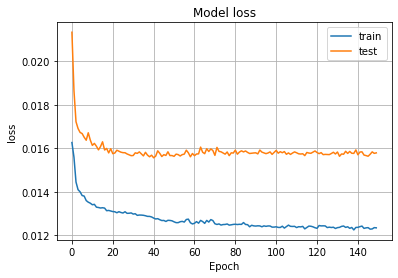

Test RMSE: 0.416
Test MAE: 0.171
Test MAPE: 0.838


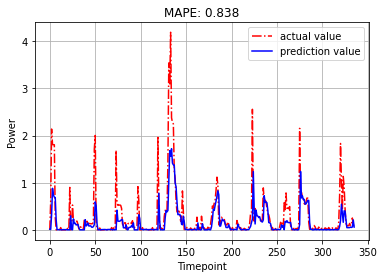

In [69]:
'''
{['n_neurons': 135, 'n_hidden': 5, 'learning_rate': 0.01, 'batch_size': 145, 'score':-0.019615494832396507]
 ['n_neurons': 228, 'n_hidden': 3, 'learning_rate': 0.001, 'batch_size': 152,'score':-0.01886052545160055']}
'''
from math import sqrt
# split into train and test sets
values = reframed.values
n_train_hours = 529*48 - 1
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]), activation="relu"))
model.add(Dropout(0.2))
model.add(LSTM(100,  return_sequences=True, activation="relu"))
model.add(Dropout(0.2))
model.add(LSTM(100,  return_sequences=False, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(learning_rate=0.0003)
model.compile(loss='mae', metrics=['mape'], optimizer=optimizer)
# fit network
history = model.fit(train_X, train_y, epochs=150, batch_size=32, validation_split=0.1, verbose=2, shuffle=False)
print(history.history.keys())
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.title('Model loss')
pyplot.xlabel('Epoch')
pyplot.ylabel('loss')
pyplot.grid(True)
pyplot.legend()
pyplot.show()


# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
mape = mean_absolute_percentage_error(inv_y, inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)

# plot actual and preidict value
pyplot.plot(range(len(inv_y)), inv_y, ls='-.', c='r', label='actual value')
pyplot.plot(range(len(inv_yhat)), inv_yhat, ls='-', c='b', label='prediction value')
pyplot.title('MAPE: %.3f' % mape)
pyplot.xlabel('Timepoint')
pyplot.ylabel('Power')
pyplot.grid(True)
pyplot.legend()
pyplot.show()

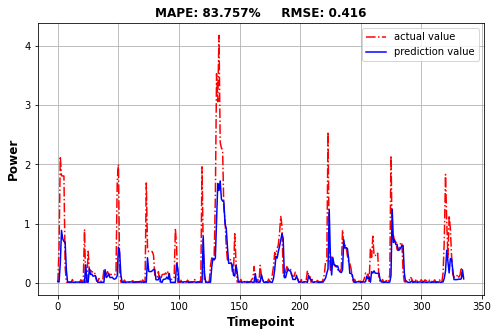

In [71]:
mape = mape*100
font1 = {'weight':'bold',
        'size':12,}
pyplot.figure(figsize=(8, 5))
pyplot.plot(range(len(inv_y)), inv_y, ls='-.', c='red', label='actual value')
pyplot.plot(range(len(inv_yhat)), inv_yhat, ls='-', c='blue', label='prediction value')
pyplot.title('MAPE: %.3f%%' % mape + '     ' + 'RMSE: %.3f' % rmse, font1)
pyplot.xlabel('Timepoint', font1)
pyplot.ylabel('Power', font1)
pyplot.grid(True)
pyplot.legend()
pyplot.savefig('LSTM_line_1283')
pyplot.show()